# Chuẩn bị dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

!unzip "/content/drive/MyDrive/Project/bird.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/TOUCHAN/003.jpg   
  inflating: train/TOUCHAN/004.jpg   
  inflating: train/TOUCHAN/005.jpg   
  inflating: train/TOUCHAN/006.jpg   
  inflating: train/TOUCHAN/007.jpg   
  inflating: train/TOUCHAN/008.jpg   
  inflating: train/TOUCHAN/009.jpg   
  inflating: train/TOUCHAN/010.jpg   
  inflating: train/TOUCHAN/011.jpg   
  inflating: train/TOUCHAN/012.jpg   
  inflating: train/TOUCHAN/013.jpg   
  inflating: train/TOUCHAN/014.jpg   
  inflating: train/TOUCHAN/015.jpg   
  inflating: train/TOUCHAN/016.jpg   
  inflating: train/TOUCHAN/017.jpg   
  inflating: train/TOUCHAN/018.jpg   
  inflating: train/TOUCHAN/019.jpg   
  inflating: train/TOUCHAN/020.jpg   
  inflating: train/TOUCHAN/021.jpg   
  inflating: train/TOUCHAN/022.jpg   
  inflating: train/TOUCHAN/023.jpg   
  inflating: train/TOUCHAN/024.jpg   
  inflating: train/TOUCHAN/025.jpg   
  inflating: train/TOUCHAN/026.jpg   
  inflating: train/TOUCHAN/027.jpg   

# Tạo ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(shear_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True)  

valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory('/content/train',
                                              color_mode='rgb',
                                              target_size=(224,224),
                                              batch_size=1024,
                                              save_format='jpg',
                                              class_mode='categorical',
                                              shuffle=True,
                                              subset='training',
                                              seed=42)


validation_generator = valid_datagen.flow_from_directory('/content/valid',
                                              color_mode='rgb',
                                              target_size=(224,224),
                                              batch_size=1024,
                                              save_format='jpg',
                                              class_mode='categorical',
                                              shuffle=True,
                                              subset='training',
                                              seed=42)
test_generator = test_datagen.flow_from_directory('/content/test',
                                              color_mode='rgb',
                                              target_size=(224,224),
                                              batch_size=32,
                                              save_format='jpg',
                                              class_mode='categorical',
                                              shuffle=True,
                                              subset='training',
                                              seed=42)

Found 36609 images belonging to 260 classes.
Found 1300 images belonging to 260 classes.
Found 1300 images belonging to 260 classes.


In [ ]:
# Take labels
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/train',
)
class_names = train_ds.class_names
print(class_names)

Found 36609 files belonging to 260 classes.
['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BROWN NOODY', 'BROWN THRASHER', 'CACTUS WREN', 'CALIFORNIA CONDOR', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CANARY', 'CAPE MAY WARBLER', 'CAPUCHINBIRD', 'CARMINE 

# Transfer learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
# from tensorflow_addons.optimizers import AdamW, CyclicalLearningRate
from tensorflow.keras.applications.resnet50 import preprocess_input 
np.random.seed(42)
import matplotlib.pyplot as plt

In [ ]:
earlystopping =  EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(filepath='/content/drive/MyDrive/Project/weights_resnet_adamw_cyclical.hdf5',
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True)
callbacks = [model_checkpoint_callback,earlystopping]

In [ ]:
base_model = ResNet50(input_shape=(224,224,3),
                        include_top=False,
                        weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(260, activation='softmax')
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
x = Dense(2048)(x)

outputs = prediction_layer(x)
model = Model(inputs, outputs)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196

## Training




In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, callbacks=callbacks,epochs=15)


In [ ]:
model.load_weights('/content/drive/MyDrive/Project/weights_resnet_adamw_cyclical.hdf5')

ValueError: ignored

In [ ]:
model.save_weights('/content/drive/MyDrive/Project/weights_resnet50.h5')
model.save('/content/drive/MyDrive/Project/model_resnet50.h5')

NameError: ignored

In [ ]:

model = tf.keras.models.load_model('/content/drive/MyDrive/Project/model_resnet50.h5')


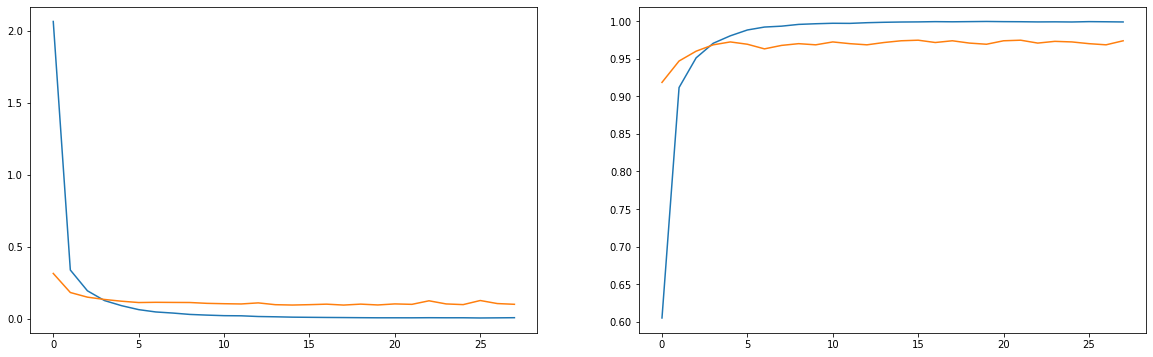

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
model.evaluate(train_generator)
model.evaluate(validation_generator)
model.evaluate(test_generator)

NameError: ignored

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, x_test, y_test)
plt.show()

ValueError: ignored

# Fine-tuning 


In [ ]:
base_model.trainable = True
print(len(base_model.layers))
for layer in base_model.layers[:150]:
  layer.trainable = False
base_learning_rate = 0.0001
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(len(model.trainable_variables))
print(model.summary())

175
34
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)             

In [ ]:
history_fine = model.fit(train_generator, validation_data=validation_generator, callbacks=callbacks, epochs=10)

Epoch 1/10
36/36 [==============================] - 472s 12s/step - loss: 5.0215 - accuracy: 0.2385 - val_loss: 0.3486 - val_accuracy: 0.9000
Epoch 2/10
36/36 [==============================] - 417s 12s/step - loss: 0.4868 - accuracy: 0.8695 - val_loss: 0.1522 - val_accuracy: 0.9569
Epoch 3/10
36/36 [==============================] - 420s 12s/step - loss: 0.2323 - accuracy: 0.9362 - val_loss: 0.1289 - val_accuracy: 0.9685
Epoch 4/10
36/36 [==============================] - 421s 12s/step - loss: 0.1417 - accuracy: 0.9590 - val_loss: 0.1137 - val_accuracy: 0.9654
Epoch 5/10
36/36 [==============================] - 424s 12s/step - loss: 0.1122 - accuracy: 0.9677 - val_loss: 0.0995 - val_accuracy: 0.9769
Epoch 6/10
36/36 [==============================] - 421s 12s/step - loss: 0.0817 - accuracy: 0.9778 - val_loss: 0.0877 - val_accuracy: 0.9723
Epoch 7/10
36/36 [==============================] - 420s 12s/step - loss: 0.0669 - accuracy: 0.9791 - val_loss: 0.0896 - val_accuracy: 0.9738
Epoch 

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/test',image_size=(224,
    224),
)


Found 1300 files belonging to 260 classes.


In [ ]:
x_test, y_test = [], []
for images, labels in test_ds.unbatch():
  x_test.append(images.numpy())
  y_test.append(labels.numpy())
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)
x_test=x_test/255
print(x_test.shape)
print(y_test.shape)



(1300, 224, 224, 3)
(1300, 1)


In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
print(y_test.shape)
y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred.reshape(-1,1)
print(y_pred.shape)


(1300, 1)
(1300, 1)


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

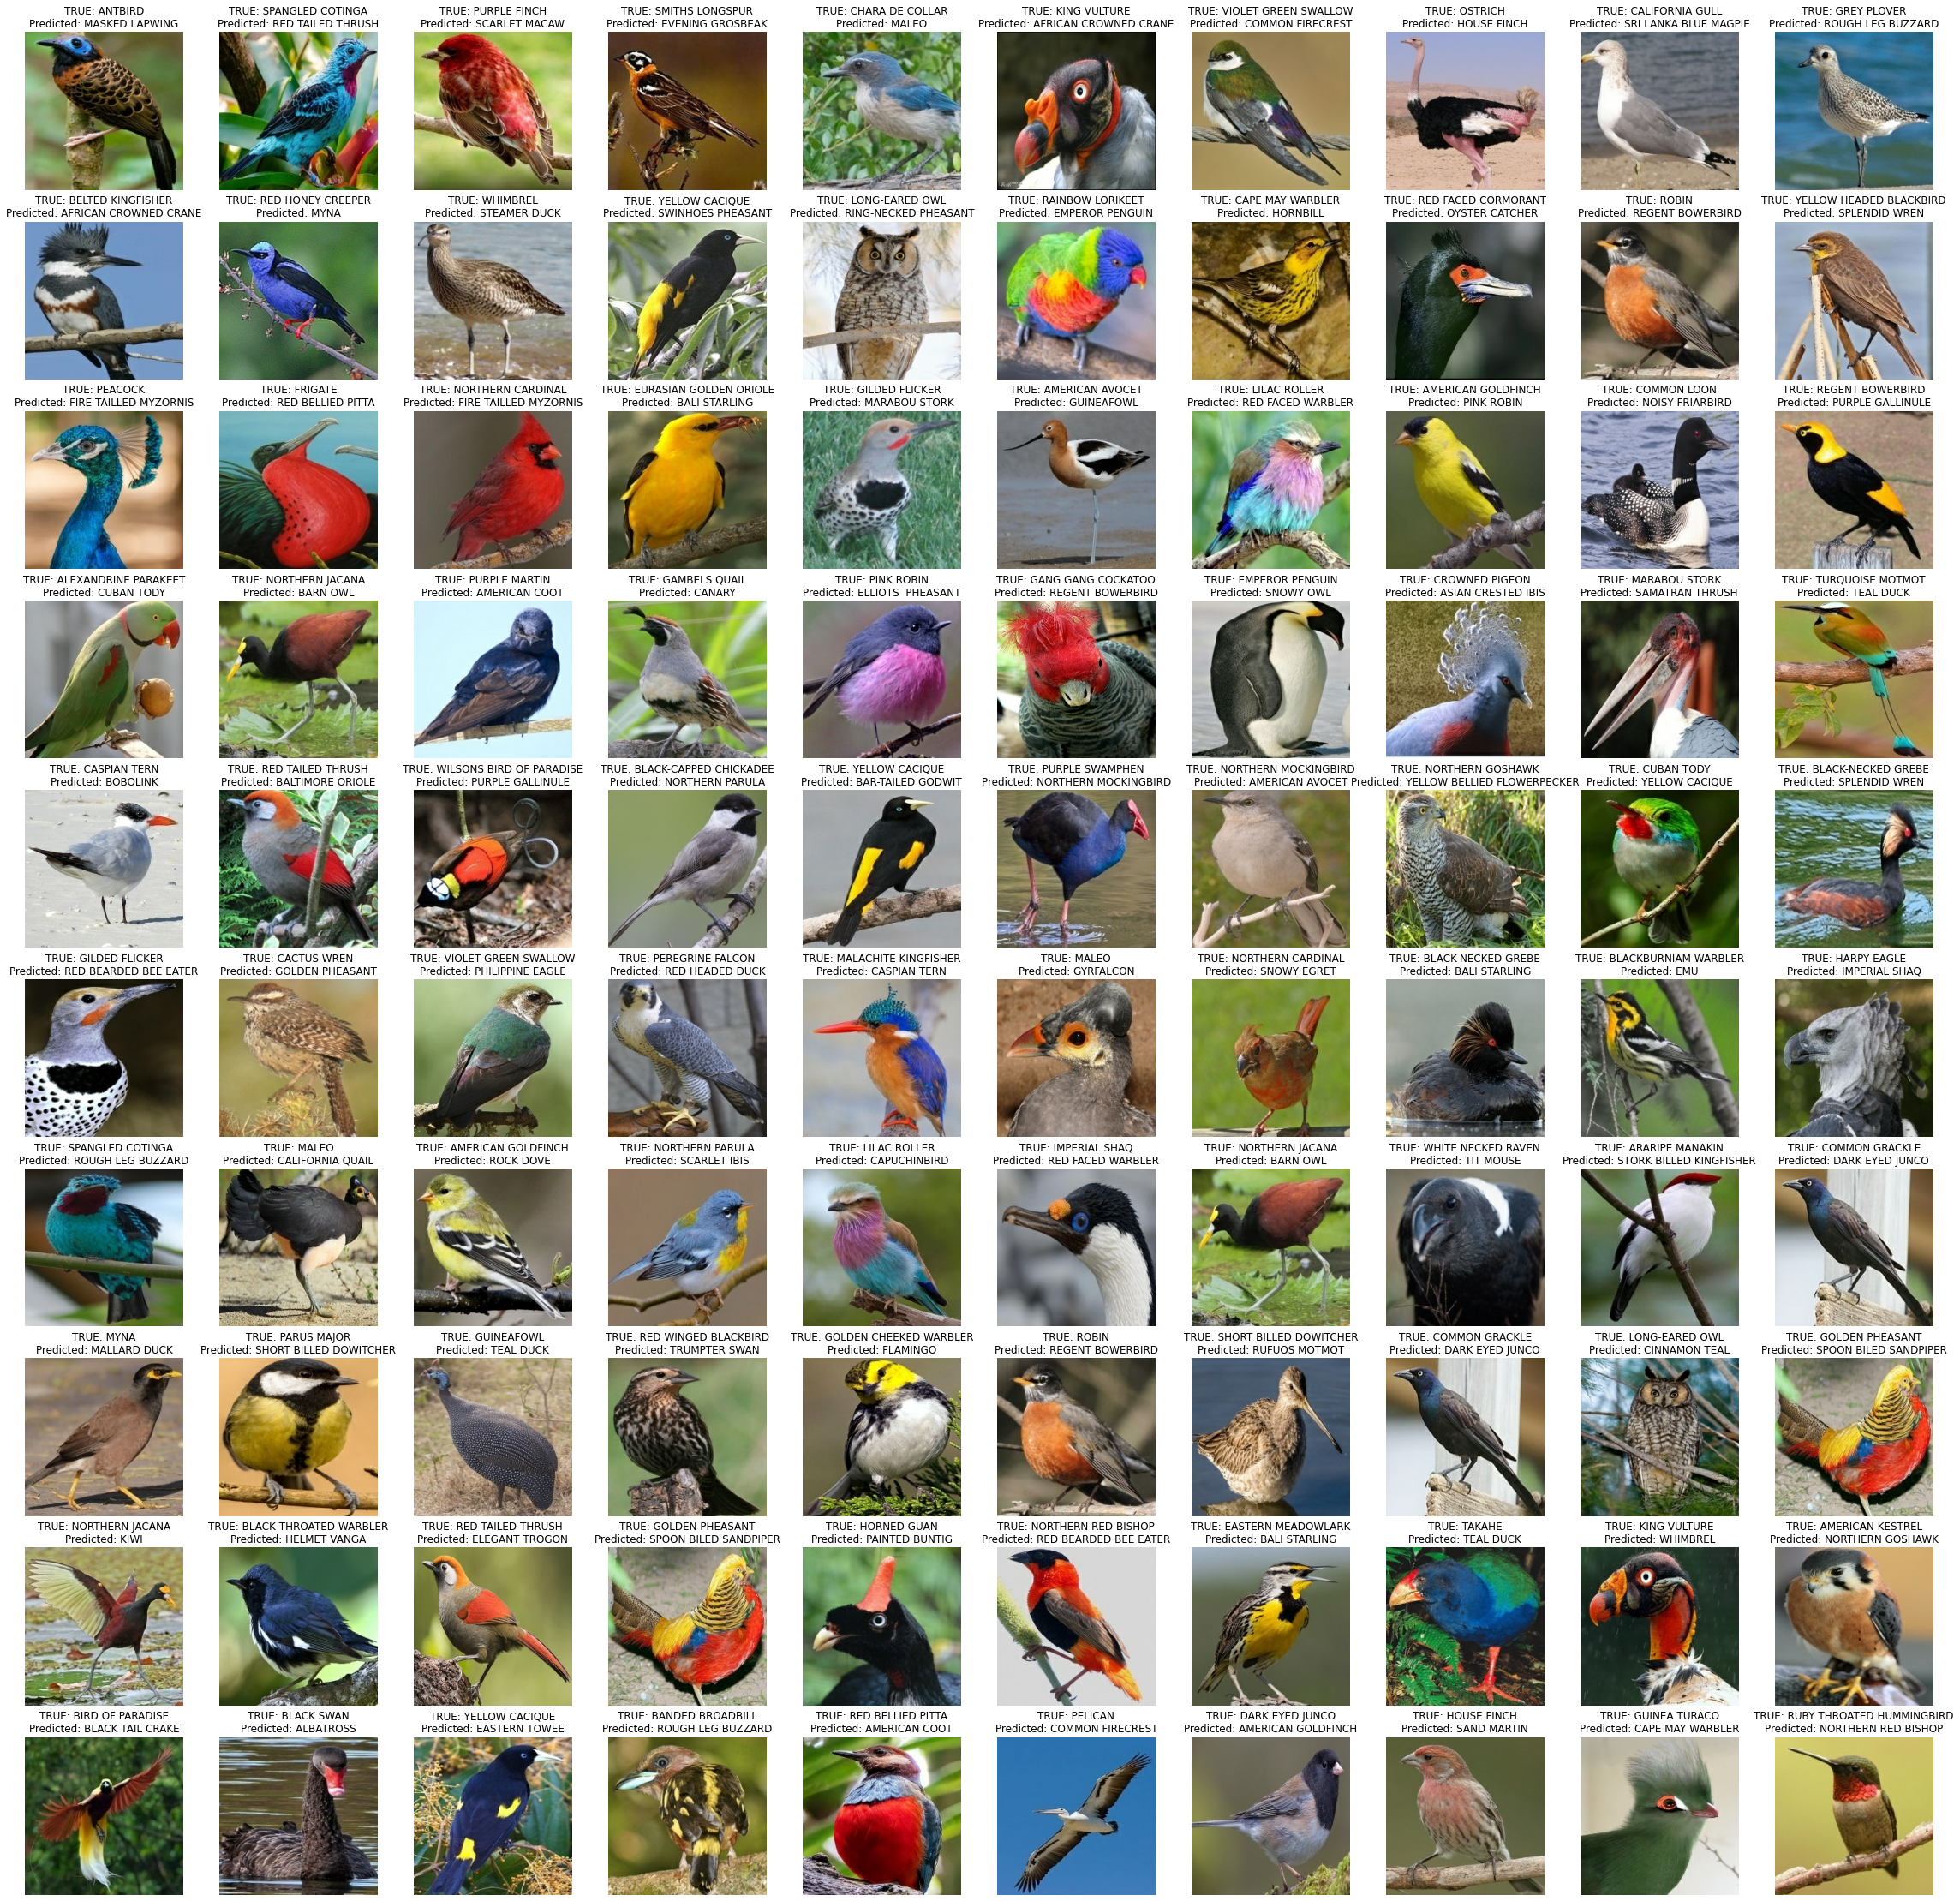

In [ ]:
# dùng mô hình để dự báo trên tập Test
y_pred = model.predict(test_generator)
# Dùng argmax để lấy ra true label
y_pred = np.argmax(y_pred, axis=1)
# tìm những vị trí mà y_pred khác y_test
wrong_predict = np.where(y_pred != np.squeeze(y_test))[0]

fig, axs = plt.subplots(10,10, figsize=(40,40))
for i in range(10):
  for j in range(10):
    # random 1 index bất kì trong các dự báo sai
    target = np.random.choice(wrong_predict)
    axs[i][j].grid('off')
    axs[i][j].axis('off')
    axs[i][j].imshow(x_test[target])  
    name = 'TRUE: {}\nPredicted: {}'.format(class_names[y_test[target][0]], class_names[y_pred[target]])
    axs[i][j].set_title(name)
plt.show()


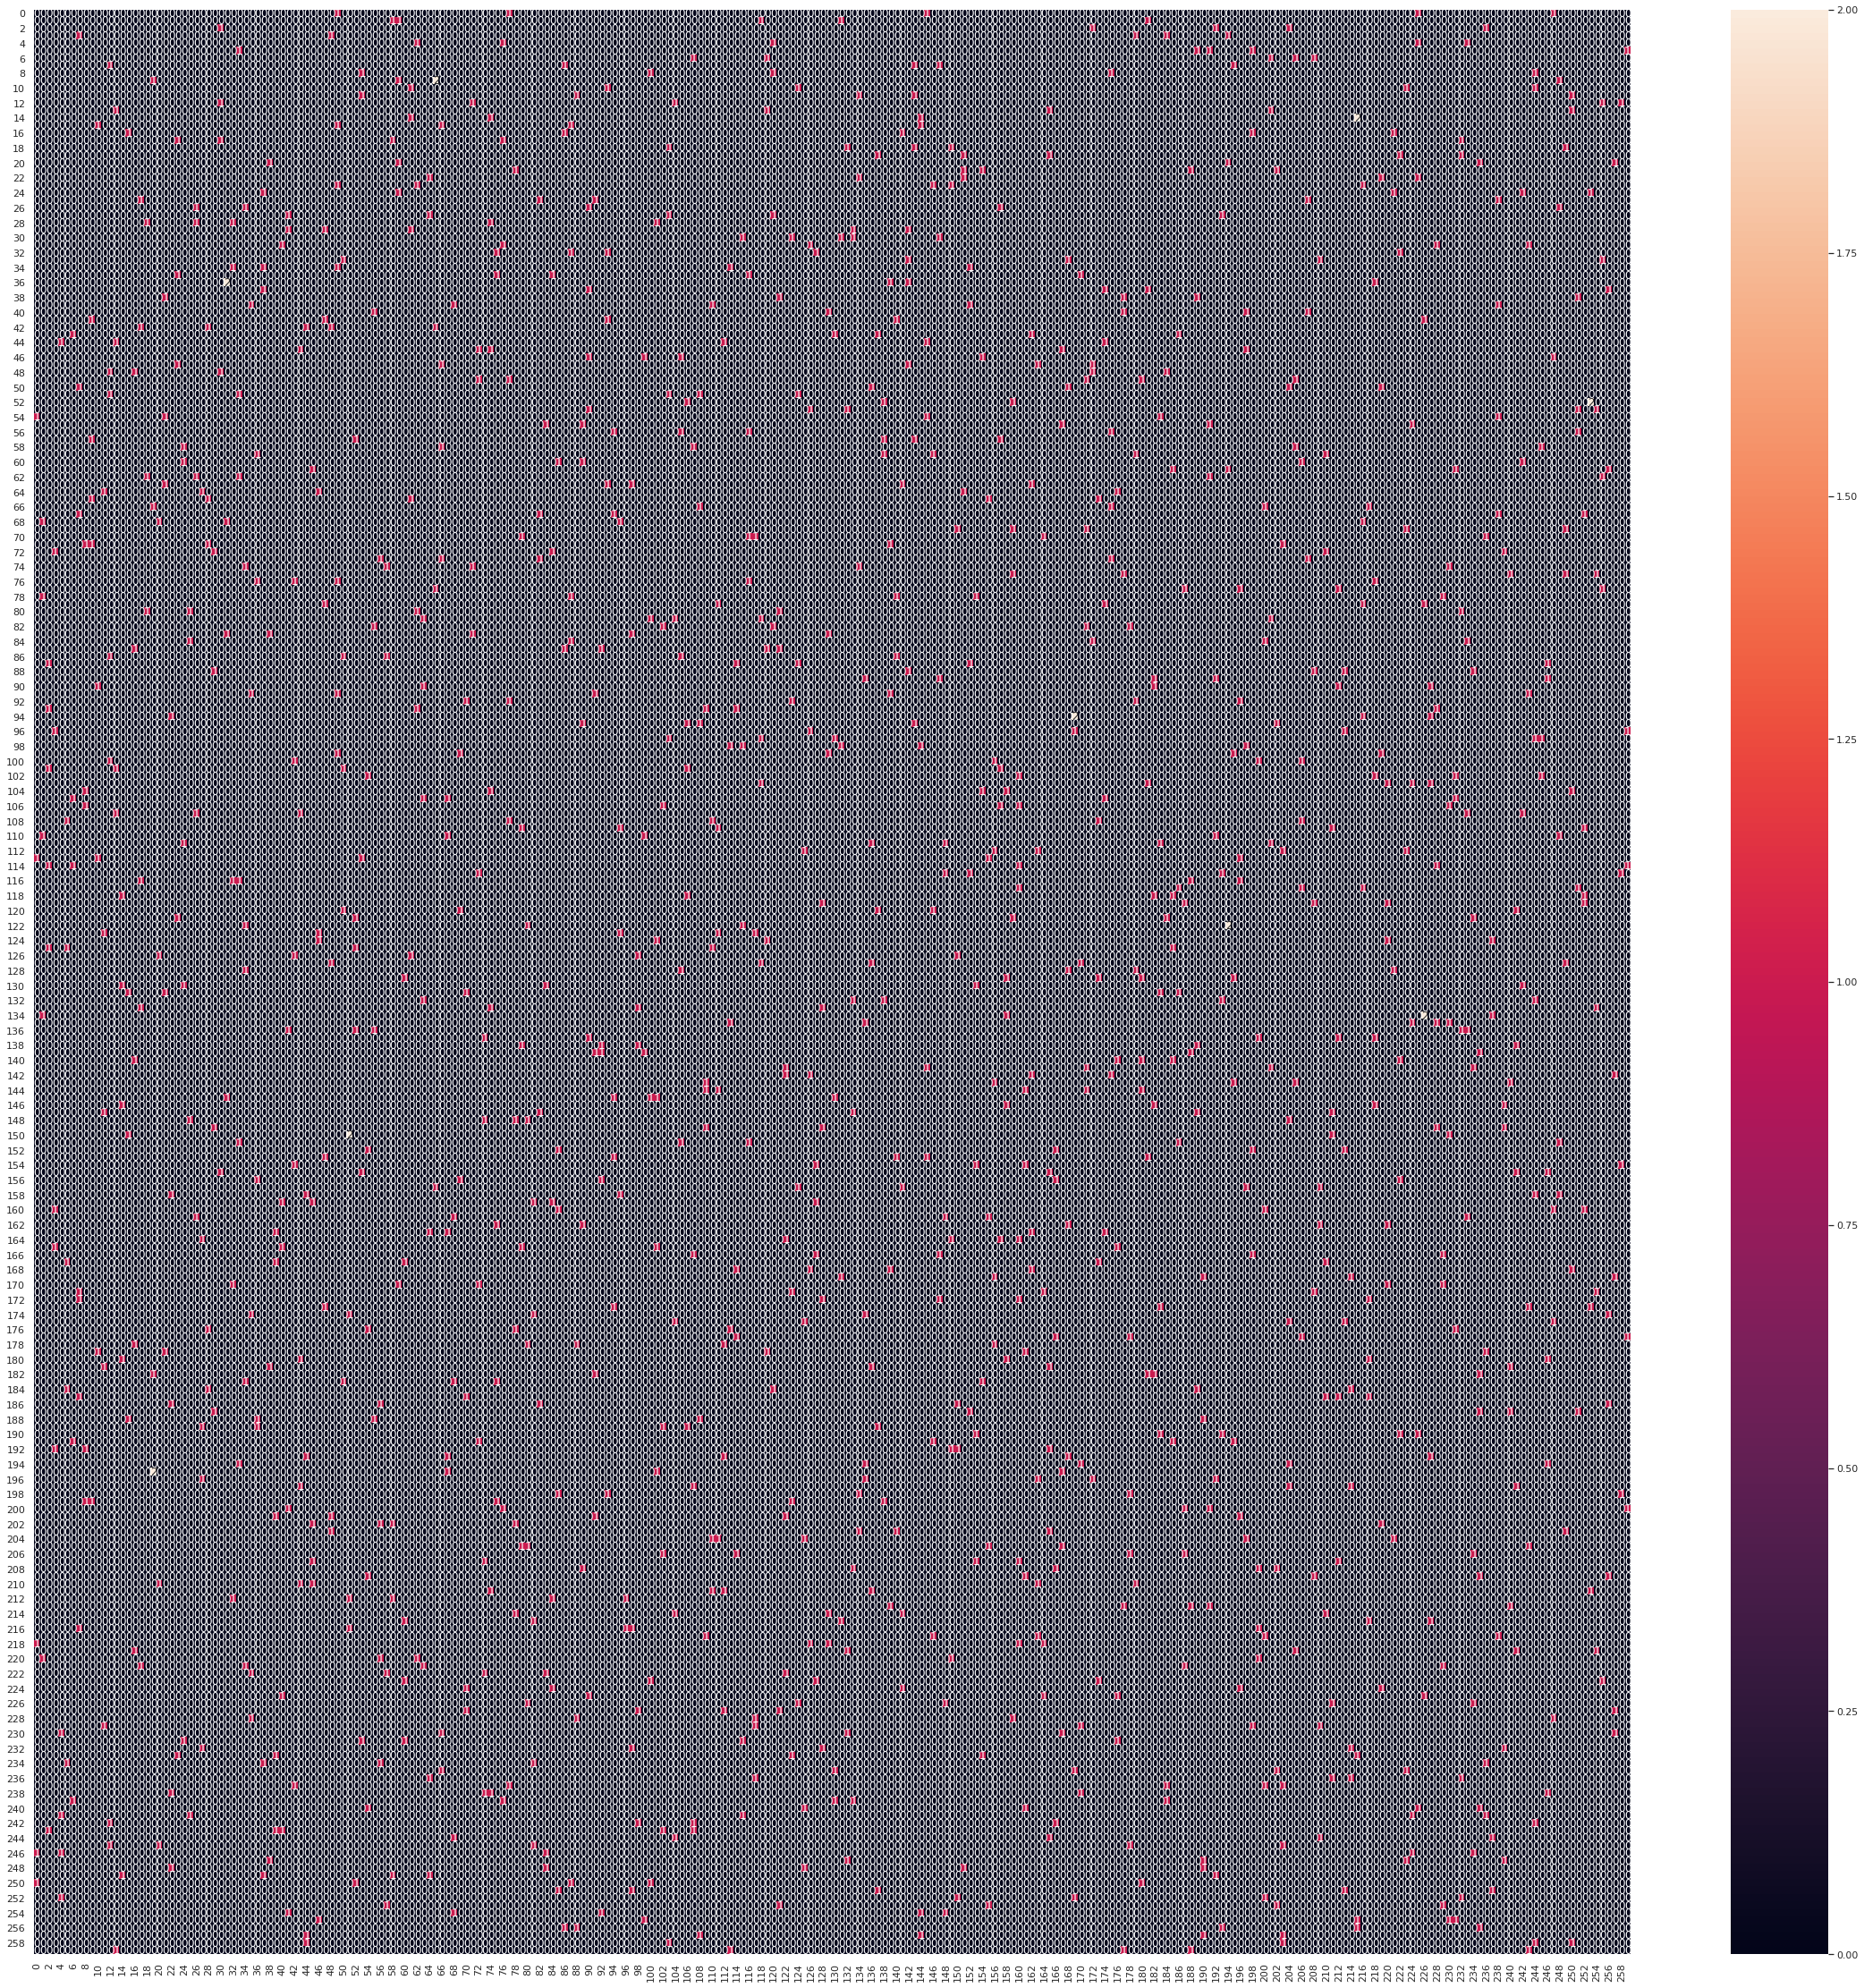

In [ ]:
import seaborn as sns 
sns.set()
plt.figure(figsize=(40,40))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            )

plt.show()